In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
import cv2
import os

In [13]:
data_dir = '/content/drive/My Drive/Datasets/chest_xray/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
val_dir = os.path.join(data_dir, 'val/')

In [17]:
def preprocess_image(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (224, 224))
  img = img/255.0
  return img

def load_data(directory):
  images = []
  labels = []
  classes = ['NORMAL', 'PNEUMONIA']
  for label in classes:
    class_dir = os.path.join(directory, label)
    for img_name in os.listdir(class_dir):
      img_path = os.path.join(class_dir, img_name)
      img = preprocess_image(img_path)
      images.append(img)
      labels.append(0 if label == 'NORMAL' else 1)
  return np.array(images), np.array(labels)

In [18]:
train_images, train_labels = load_data(train_dir)
print("Training data loaded and preprocessed")

Training data loaded and preprocessed


In [19]:
val_images, val_labels = load_data(val_dir)
print("Validation data loaded and preprocessed")

Validation data loaded and preprocessed


In [20]:
test_images, test_labels = load_data(test_dir)
print("Testing data loaded and preprocessed")

Testing data loaded and preprocessed


In [21]:
print(f'Training data shape: {train_images.shape}, {train_labels.shape}')
print(f'Validation data shape: {val_images.shape}, {val_labels.shape}')
print(f'Testing data shape: {test_images.shape}, {test_labels.shape}')

Training data shape: (5216, 224, 224), (5216,)
Validation data shape: (16, 224, 224), (16,)
Testing data shape: (624, 224, 224), (624,)


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_images_augmented = train_images.reshape(train_images.shape[0], 224, 224, 1)  # Reshape for ImageDataGenerator
train_generator = datagen.flow(train_images_augmented, train_labels, batch_size=32)


In [28]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [32]:
class_weight = {0: 1., 1: 0.6}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=len(train_images) // 32,
                    epochs=20,
                    validation_data=(val_images.reshape(val_images.shape[0], 224, 224, 1), val_labels),
                    class_weight=class_weight,
                    callbacks=[early_stopping])


Epoch 1/20
163/163 [==============================] - 24s 147ms/step - loss: 0.1860 - accuracy: 0.8936 - val_loss: 0.7131 - val_accuracy: 0.6875
Epoch 2/20
163/163 [==============================] - 25s 155ms/step - loss: 0.1813 - accuracy: 0.8995 - val_loss: 0.5475 - val_accuracy: 0.7500
Epoch 3/20
163/163 [==============================] - 23s 140ms/step - loss: 0.1866 - accuracy: 0.8986 - val_loss: 0.4463 - val_accuracy: 0.7500
Epoch 4/20
163/163 [==============================] - 26s 157ms/step - loss: 0.1732 - accuracy: 0.9080 - val_loss: 0.7948 - val_accuracy: 0.6875
Epoch 5/20
163/163 [==============================] - 24s 146ms/step - loss: 0.1808 - accuracy: 0.9059 - val_loss: 0.4309 - val_accuracy: 0.7500
Epoch 6/20
163/163 [==============================] - 24s 149ms/step - loss: 0.1728 - accuracy: 0.9091 - val_loss: 0.6472 - val_accuracy: 0.7500
Epoch 7/20
163/163 [==============================] - 25s 152ms/step - loss: 0.1671 - accuracy: 0.9086 - val_loss: 0.8644 - val_ac

20/20 [==============================] - 0s 17ms/step - loss: 0.3024 - accuracy: 0.8894
Test accuracy: 0.8894
20/20 [==============================] - 0s 12ms/step


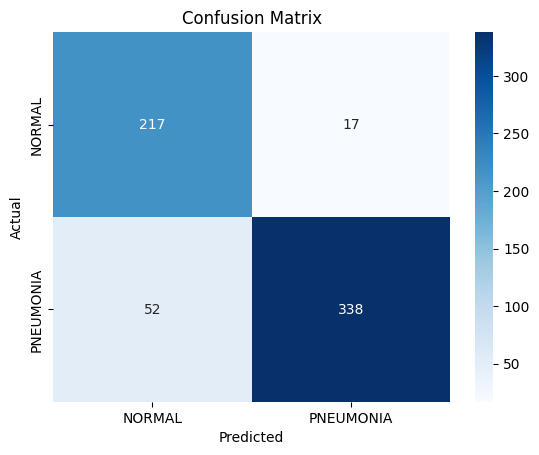

              precision    recall  f1-score   support

      NORMAL       0.81      0.93      0.86       234
   PNEUMONIA       0.95      0.87      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.90      0.89       624
weighted avg       0.90      0.89      0.89       624



In [34]:
test_loss, test_accuracy = model.evaluate(test_images.reshape(test_images.shape[0], 224, 224, 1), test_labels)
print(f'Test accuracy: {test_accuracy:.4f}')

test_predictions = model.predict(test_images.reshape(test_images.shape[0], 224, 224, 1))
test_predictions = (test_predictions > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(test_labels, test_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(test_labels, test_predictions, target_names=['NORMAL', 'PNEUMONIA'])
print(class_report)


In [35]:
model.save('/content/drive/My Drive/PneumoniaDetectionProject/model/pneumonia_detection_model.h5')
print("Model saved successfully.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      